In [1]:
import hydrofunctions as hf
import matplotlib.pyplot as plt
import json
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
# https://hydrofunctions.readthedocs.io/en/master/
# help(hf.NWIS)

In [3]:
# From Docs: "The Daily Mean discharge data are great for situations where you want to know the baseflow of a watershed, or the volume of water that is entering a reservoir or if you want to learn about the long-term hydrology of a watershed."

# Parameters
param = '00060' # discharge
start = "2011-02-15"
end = "2021-04-15"
service = "dv"
state = 'co'

# Pulling data
co = hf.NWIS(None, service, start, end, parameterCd=param, stateCd=state)

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&stateCd=co&parameterCd=00060&startDT=2011-02-15&endDT=2021-04-15


In [4]:
# Changing to dataframe
all_data = co.df('data')

# Dataframe information
n = all_data.shape[0]
print(f'The total length of samples (days) is {n}.')
all_data.head()

The total length of samples (days) is 3713.


USGS:06613950:00060:00003  \
datetimeUTC                                            
2011-02-15 00:00:00+00:00                        NaN   
2011-02-16 00:00:00+00:00                        NaN   
2011-02-17 00:00:00+00:00                        NaN   
2011-02-18 00:00:00+00:00                        NaN   
2011-02-19 00:00:00+00:00                        NaN   

                           USGS:06614800:00060:00003  \
datetimeUTC                                            
2011-02-15 00:00:00+00:00                       0.45   
2011-02-16 00:00:00+00:00                       0.45   
2011-02-17 00:00:00+00:00                       0.45   
2011-02-18 00:00:00+00:00                       0.45   
2011-02-19 00:00:00+00:00                       0.45   

                           USGS:06620000:00060:00003  \
datetimeUTC                                            
2011-02-15 00:00:00+00:00                      130.0   
2011-02-16 00:00:00+00:00                      135.0   
2011-02-17 00:00:00+00:00                      140.0   
2011-02-18 00:00:00+00:00                      135.0   
2011-02-19 00:00:00+00:00                      135.0   

                           USGS:06659580:00060:00003  \
datetimeUTC                                            
2011-02-15 00:00:00+00:00                        NaN   
2011-02-16 00:00:00+00:00                        NaN   
2011-02-17 00:00:00+00:00                        NaN   
2011-02-18 00:00:00+00:00                        NaN   
2011-02-19 00:00:00+00:00                        NaN   

                           USGS:06696980:00060:00003  \
datetimeUTC                                            
2011-02-15 00:00:00+00:00                        NaN   
2011-02-16 00:00:00+00:00                        NaN   
2011-02-17 00:00:00+00:00                        NaN   
2011-02-18 00:00:00+00:00                        NaN   
2011-02-19 00:00:00+00:00                        NaN   

                           USGS:06700000:00060:00003  \
datetimeUTC                                            
2011-02-15 00:00:00+00:00                        NaN   
2011-02-16 00:00:00+00:00                        NaN   
2011-02-17 00:00:00+00:00                        NaN   
2011-02-18 00:00:00+00:00                        NaN   
2011-02-19 00:00:00+00:00                        NaN   

                           USGS:06701620:00060:00003  \
datetimeUTC                                            
2011-02-15 00:00:00+00:00                        NaN   
2011-02-16 00:00:00+00:00                        NaN   
2011-02-17 00:00:00+00:00                        NaN   
2011-02-18 00:00:00+00:00                        NaN   
2011-02-19 00:00:00+00:00                        NaN   

                           USGS:06701700:00060:00003  \
datetimeUTC                                            
2011-02-15 00:00:00+00:00                        NaN   
2011-02-16 00:00:00+00:00                        NaN   
2011-02-17 00:00:00+00:00                        NaN   
2011-02-18 00:00:00+00:00                        NaN   
2011-02-19 00:00:00+00:00                        NaN   

                           USGS:06701900:00060:00003  \
datetimeUTC                                            
2011-02-15 00:00:00+00:00                      110.0   
2011-02-16 00:00:00+00:00                      135.0   
2011-02-17 00:00:00+00:00                      167.0   
2011-02-18 00:00:00+00:00                      151.0   
2011-02-19 00:00:00+00:00                      134.0   

                           USGS:06708600:00060:00003  ...  \
datetimeUTC                                           ...   
2011-02-15 00:00:00+00:00                        NaN  ...   
2011-02-16 00:00:00+00:00                        NaN  ...   
2011-02-17 00:00:00+00:00                        NaN  ...   
2011-02-18 00:00:00+00:00                        NaN  ...   
2011-02-19 00:00:00+00:00                        NaN  ...   

                           USGS:392547106023400:00060:00003  \

New Data with Removed Columns...


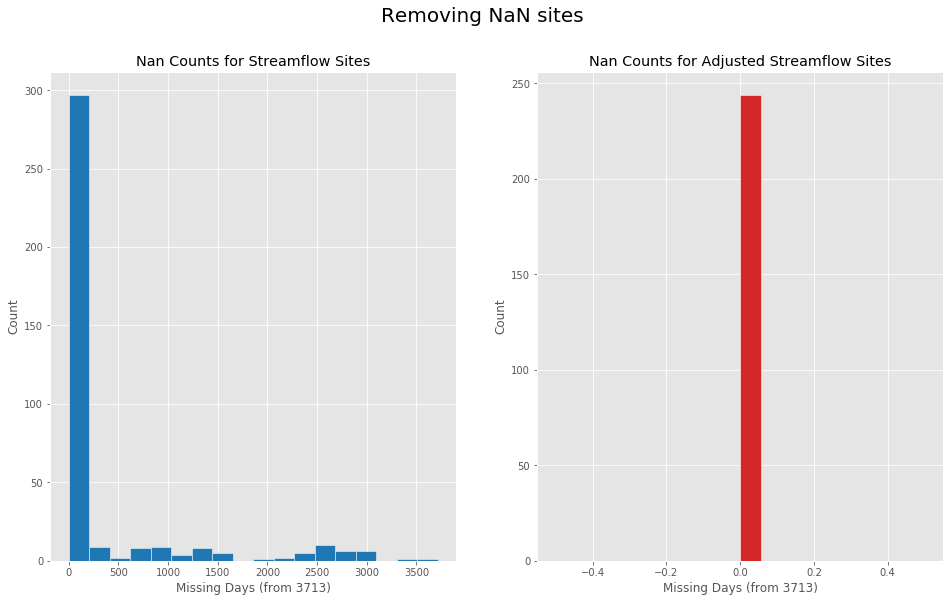

In [157]:
# Decide which sites to keep
tol = 0.025 # we discard any site that has more than X% of the days missing
site_nan_counts = all_data.isnull().sum(axis = 0).values

# Remove columns that do not satisfy length
boolean_column_drop = site_nan_counts <= 0
data = all_data[all_data.columns[boolean_column_drop]]
site_nan_counts_new = data.isnull().sum(axis = 0).values

# Plotting missing days as histogram
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle(f'Removing NaN sites', fontsize=20)

# All sites
ax1.hist(site_nan_counts, bins=18, color='tab:blue', ec='white')
ax1.set_title('Nan Counts for Streamflow Sites')
ax1.set_xlabel(f'Missing Days (from {data.shape[0]})')
ax1.set_ylabel('Count')

# New Sites
ax2.hist(site_nan_counts_new, bins=18, color='tab:red', ec='white')
ax2.set_title('Nan Counts for Adjusted Streamflow Sites')
ax2.set_xlabel(f'Missing Days (from {data.shape[0]})')
ax2.set_ylabel('Count')

print('New Data with Removed Columns...')
data.head()

fig.savefig('removing_nan_sites')

So here, we notice that we have a decent amount of sites that contain data all the way back 10 years (about 300) but we also have the 
rest lacking lots of information, as much as 3000 days.

# Finding Lat and Long of each site

In [6]:
# We do this first for all sites... (change later)
site_IDs = []
for site in data.columns:
    x = site.split(":")
    site_IDs.append(x[1])
    
print(f'First 5 site ID\'s: {site_IDs[:5]}')

First 5 site ID's: ['06614800', '06620000', '06701900', '06708800', '06709000']


In [7]:
# Dictionary for site ID, lat, and long
site_coor = {}

# Iterate through IDs and store lat and long
for i,ID in enumerate(site_IDs):
    site_coor[i] = {}
    lat = co.meta['USGS:' + ID]['siteLatLongSrs']['latitude']
    lon = co.meta['USGS:' + ID]['siteLatLongSrs']['longitude']

    site_coor[i]['siteID'] = ID
    site_coor[i]['lat'] = lat
    site_coor[i]['lon'] = lon

print(f'Example of first two sites:\n {list(site_coor.values())[:2]}')
with open('site_coordinates.json', 'w') as fp:
    json.dump(site_coor, fp)

Example of first two sites:
 [{'siteID': '06614800', 'lat': 40.49609409, 'lon': -105.8650119}, {'siteID': '06620000', 'lat': 40.93663889, 'lon': -106.3391944}]


# Plotting Lat and Long on Discretized Grid

In [27]:
list(site_coor.items())

[(0, {'siteID': '06614800', 'lat': 40.49609409, 'lon': -105.8650119}),
 (1, {'siteID': '06620000', 'lat': 40.93663889, 'lon': -106.3391944}),
 (2, {'siteID': '06701900', 'lat': 39.25999025, 'lon': -105.2219379}),
 (3, {'siteID': '06708800', 'lat': 39.423, 'lon': -104.9046111}),
 (4, {'siteID': '06709000', 'lat': 39.43832246, 'lon': -104.9830387}),
 (5, {'siteID': '06709530', 'lat': 39.50736944, 'lon': -105.0244667}),
 (6, {'siteID': '06710150', 'lat': 39.5633216, 'lon': -104.927758}),
 (7, {'siteID': '06710247', 'lat': 39.6324876, 'lon': -105.014983}),
 (8, {'siteID': '06710385', 'lat': 39.63316667, 'lon': -105.3369444}),
 (9, {'siteID': '06711565', 'lat': 39.66498738, 'lon': -105.004149}),
 (10, {'siteID': '06712000', 'lat': 39.3558234, 'lon': -104.7633092}),
 (11, {'siteID': '06713500', 'lat': 39.74248685, 'lon': -104.9999817}),
 (12, {'siteID': '06714215', 'lat': 39.81220846, 'lon': -104.9583129}),
 (13, {'siteID': '06715000', 'lat': 39.7519319, 'lon': -105.661947}),
 (14, {'siteID'

Text(0, 0.5, 'Latitude')

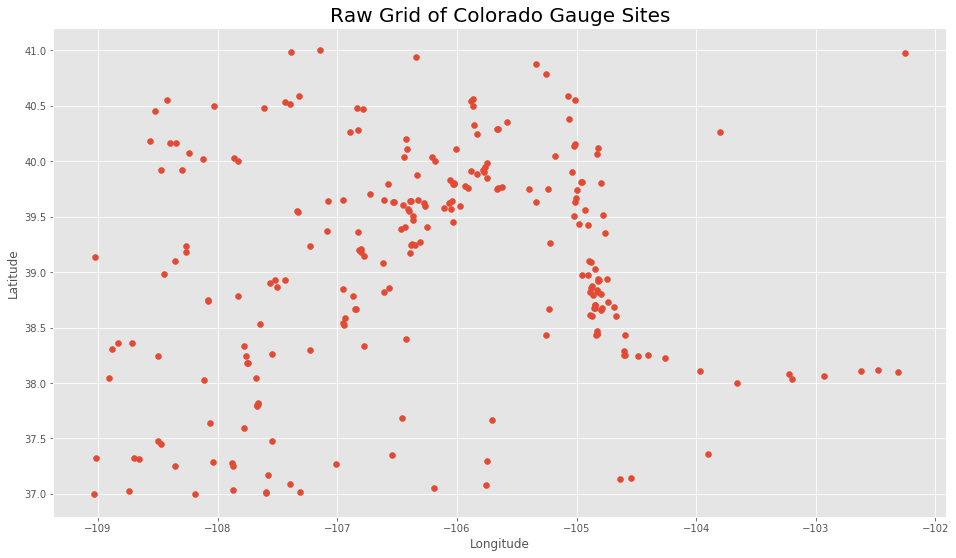

In [8]:
# Saving lat and long as euclidean (projection needed technically)
x = []
y = []

# Iterate through dictionary
for key, site in site_coor.items():
    x.append(site['lon'])
    y.append(site['lat'])

# Raw Plot
plt.scatter(x, y)
plt.title('Raw Grid of Colorado Gauge Sites', fontsize='20')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [9]:
xedges = np.linspace(-110, -102, num=50)
yedges = np.linspace(37, 41, num=50)

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges)) # x = long, y = lat

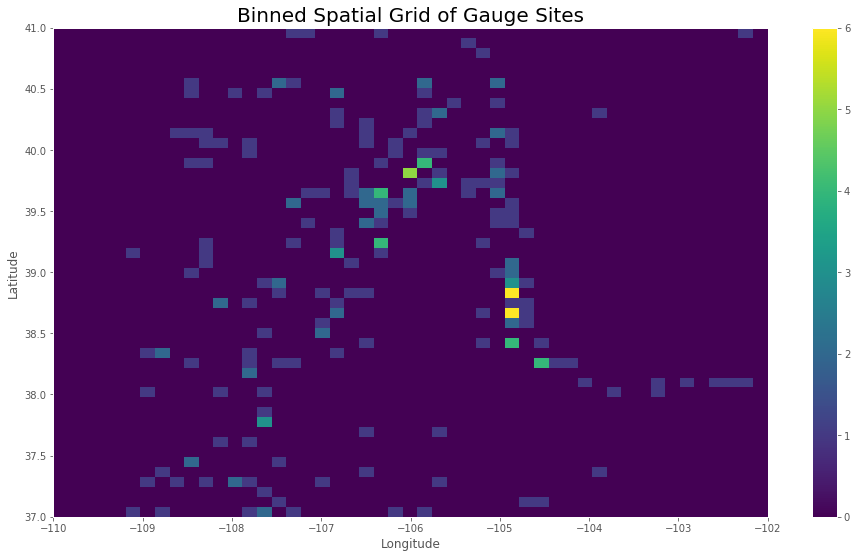

In [10]:
plt.hist2d(x, y, bins = [xedges, yedges])
plt.title('Binned Spatial Grid of Gauge Sites', fontsize=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

In [11]:
#read SnoTel location data
file2 = open("SnoLocations.pkl", 'rb')
SnoLocations = pickle.load(file2)
file2.close()

In [12]:
sno_coor = np.array(list(SnoLocations.values()))

In [13]:
sno_coor[0:5,:]

array([[  40.43254, -105.73337],
       [  37.79926, -107.92426],
       [  37.43087, -108.16954],
       [  37.47922, -106.8017 ],
       [  40.34703, -106.09433]])

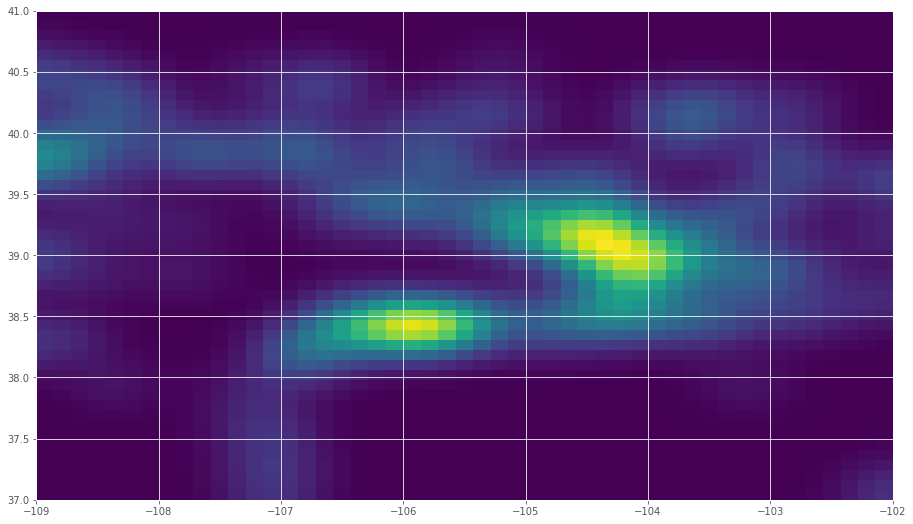

In [14]:
H_sno, xedges, yedges = np.histogram2d(sno_coor[:,1], sno_coor[:,0], bins=(xedges, yedges))
heatmap = gaussian_filter(H, sigma=2)
plt.imshow(heatmap, extent=[-109, -102, 37, 41])
# sns.kdeplot(sno_coor[:,1], sno_coor[:,0], fill=True, cmap="mako", Shade=True)

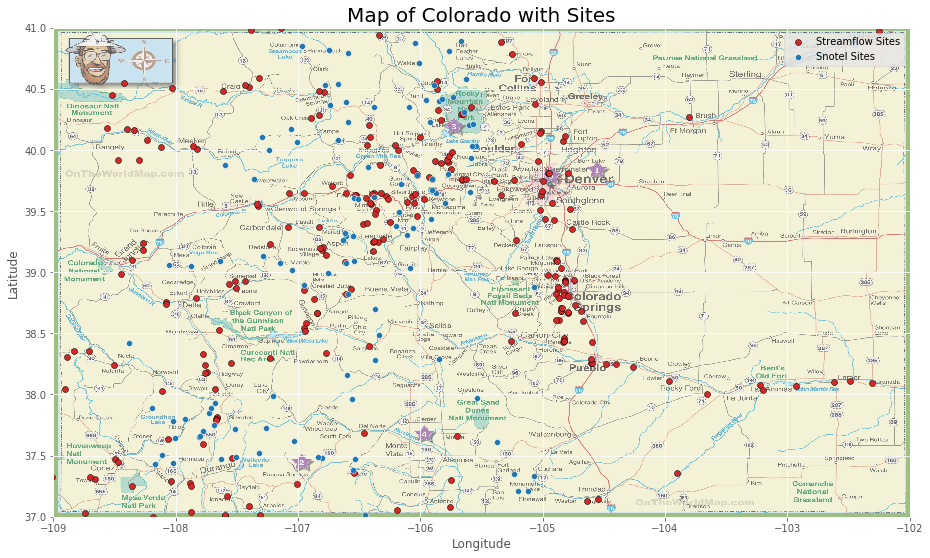

In [155]:
# Colorado Map
co_img = mpimg.imread('map_of_colorado.jpg') # source: http://ontheworldmap.com/usa/state/colorado large-detailed-map-of-colorado-with-cities-and-roads.jpg
bd_points = [-109, -102, 37, 41] # CO boundaries

# Plotting Sites
plt.title('Map of Colorado with Sites', fontsize=20)
plt.scatter(x, y, marker='o', color='tab:red', ec='black', label='Streamflow Sites')
plt.scatter(sno_coor[:,1], sno_coor[:,0], marker='o', color='tab:blue', ec='white', label='Snotel Sites')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.legend()
plt.imshow(co_img, extent=bd_points, alpha=0.6)
plt.savefig('map_of_colorado_allsites.png')

In [16]:
site_corr = json.load(open('site_coordinates.json'))

In [17]:
stream_data_dict = {}
for key, site in site_coor.items():
    site_id = site['siteID']
    stream_data = data['USGS:' + site_id + ':00060:00003']
    stream_data_dict[site_id] = stream_data
    # break
# print()
# Example of first site's historical streamflow data
print(stream_data_dict[list(site_corr.items())[0][1]['siteID']])

# Impute it before using full version for graphing!
# with open('streamflow_dict.json', 'w') as fp:
    # json.dump(stream_data_dict, fp)
print(stream_data_dict.items())

                 ...  
2021-04-11 00:00:00+00:00    588.0
2021-04-12 00:00:00+00:00    652.0
2021-04-13 00:00:00+00:00    643.0
2021-04-14 00:00:00+00:00    552.0
2021-04-15 00:00:00+00:00    541.0
Freq: D, Name: USGS:09342500:00060:00003, Length: 3713, dtype: float64), ('09346400', datetimeUTC
2011-02-15 00:00:00+00:00    144.0
2011-02-16 00:00:00+00:00    155.0
2011-02-17 00:00:00+00:00    158.0
2011-02-18 00:00:00+00:00    156.0
2011-02-19 00:00:00+00:00    154.0
                             ...  
2021-04-11 00:00:00+00:00    648.0
2021-04-12 00:00:00+00:00    717.0
2021-04-13 00:00:00+00:00    733.0
2021-04-14 00:00:00+00:00    652.0
2021-04-15 00:00:00+00:00    621.0
Freq: D, Name: USGS:09346400:00060:00003, Length: 3713, dtype: float64), ('09349800', datetimeUTC
2011-02-15 00:00:00+00:00     71.5
2011-02-16 00:00:00+00:00     79.5
2011-02-17 00:00:00+00:00     78.6
2011-02-18 00:00:00+00:00     84.0
2011-02-19 00:00:00+00:00     79.8
                             ...  
2021-04-11 

In [292]:
x = []
y = []
z = np.empty((len(list(site_coor.items())), 3713))
for i in range(len(list(site_coor.items()))):
    site_id = list(site_coor.items())[i][1]['siteID']
    lat = list(site_coor.items())[i][1]['lat']
    lon = list(site_coor.items())[i][1]['lon']

    x.append(lon)
    y.append(lat)
    for j in range(len(list(stream_data_dict.items())[0][1])):
        val = list(stream_data_dict.items())[i][1][j] # select each day

        if (list(stream_data_dict.items())[i][0] == site_id):
            z[i,j] = val

In [293]:
np.savetxt('streamflow_data.csv',z, delimiter=',')

(244,) 244 244


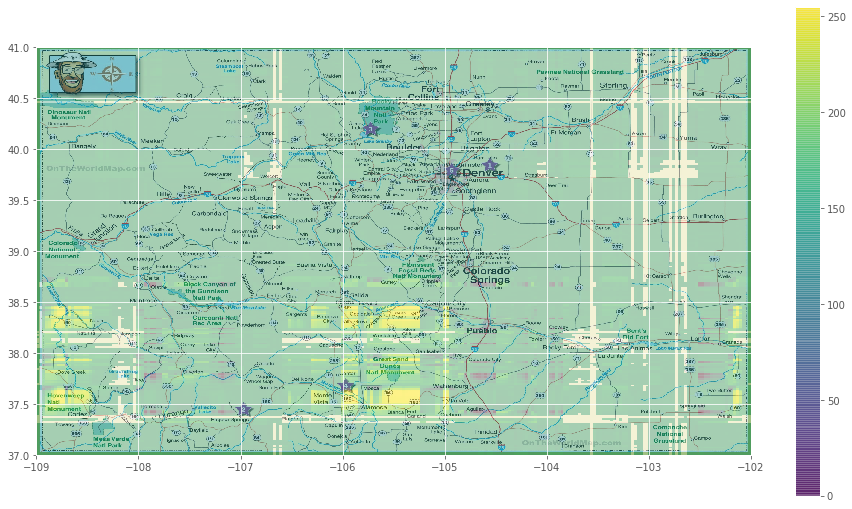

In [149]:
# z1 = np.interp(z[:,0], [min(z[:,0]), max(z[:,0])], [0,1])
# z1 = 255*z1
# z1 = np.array(z1, dtype='int')
from scipy.interpolate import griddata
grid_x, grid_y = np.meshgrid(x, y)
print(z[:,0].shape, len(x), len(y))
# grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata((x, y), z[:,0], (grid_x, grid_y), method='cubic')
plt.imshow(grid_z1.T, extent=bd_points)
# plt.imshow(grid_z1, extent=bd_points)
plt.imshow(co_img, extent=bd_points, alpha=0.6)
plt.colorbar()

ipykernel_launcher:10: RuntimeWarning: invalid value encountered in log
C:\Users\user\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\user\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


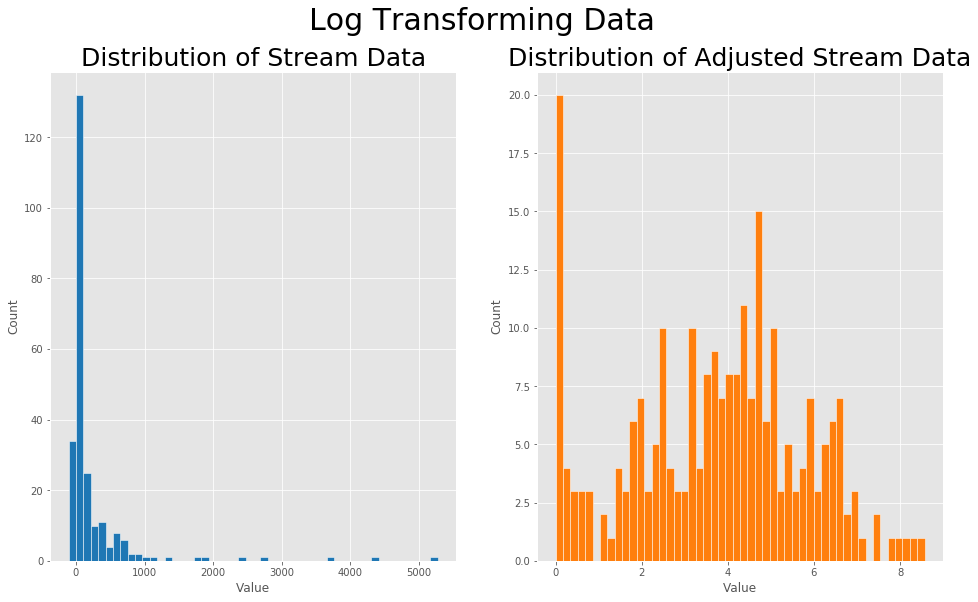

In [152]:
# Stream Data
day = 180
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Log Transforming Data', fontsize=30)
ax1.hist(z[:,day], bins=50, ec='white', color='tab:blue')
ax1.set_title('Distribution of Stream Data', fontsize=25)
ax1.set_xlabel('Value')
ax1.set_ylabel('Count')

ax2.hist(np.log(z[:,day] + 1), bins=50, ec='white', color='tab:orange')
ax2.set_title('Distribution of Adjusted Stream Data', fontsize=25)
ax2.set_xlabel('Value')
ax2.set_ylabel('Count')

fig.savefig('log_transforming.png')

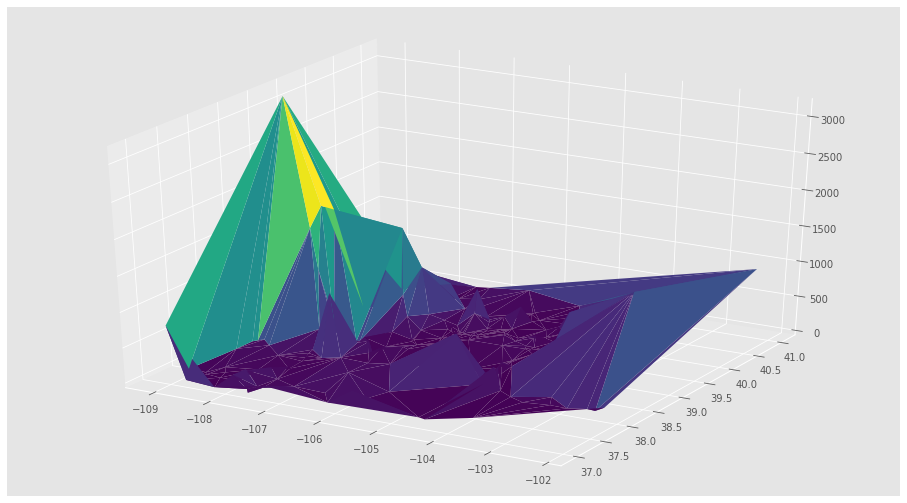

In [101]:
ax = plt.axes(projection='3d')
# z = stream_data_dict[list(site_corr.items())[0][1]['siteID']].values
# z_heatmap = gaussian_filter(z, sigma=50)
ax.plot_trisurf(x, y, z[:,0], cmap='viridis', edgecolor='none')

ipykernel_launcher:7: RuntimeWarning: invalid value encountered in log


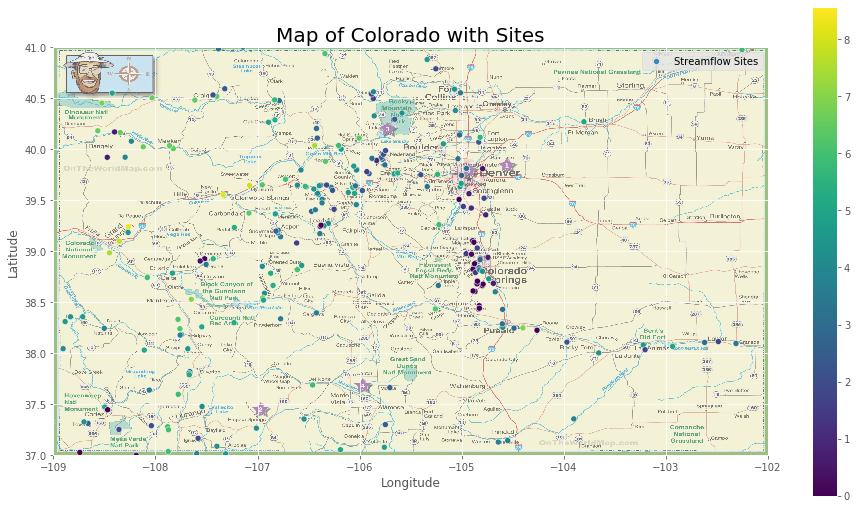

In [153]:
# Colorado Map
co_img = mpimg.imread('map_of_colorado.jpg') # source: http://ontheworldmap.com/usa/state/colorado large-detailed-map-of-colorado-with-cities-and-roads.jpg
bd_points = [-109, -102, 37, 41] # CO boundaries

# Plotting Sites
plt.title('Map of Colorado with Sites', fontsize=20)
plt.scatter(x, y, marker='o', c=np.log(z[:,day] + 1), ec='white', label='Streamflow Sites')
plt.colorbar()
# sns.scatterplot(data=tips, x="total_bill", y="tip", hue="size")
# plt.scatter(sno_coor[:,1], sno_coor[:,0], marker='o', color='tab:blue', ec='white', label='Snotel Sites')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.legend()
plt.imshow(co_img, extent=bd_points, alpha=0.6)
plt.savefig('map_of_colorado_sites.png')

## Modeling Test

In [282]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [294]:
# Perparing Data
z = z.T
# z_stdized = (z - np.mean(z, axis=0)) / np.std(z)

In [297]:
z_scaled = np.empty((1, z.shape[1]))
y_scaled = np.empty((1, z.shape[1]))
for i in range(0, 9):
    z_slice = z[i*371 + 275:(i+1)*371 + 275,:]
    # print(z_slice.shape)
    y_slice = np.cumsum(z_slice, axis=0)
    # print(y_slice.shape)
    # print(((y_slice - np.mean(y_slice, axis=0)) / np.std(y_slice)).shape)
    # break
    # y_slice = y[i*371:(i+1)*371,:]
    z_adj = (z_slice - np.mean(z_slice, axis=0)) / np.std(z_slice)
    y_adj = (y_slice - np.mean(y_slice, axis=0)) / np.std(y_slice)

    # print(z_adj.shape, y_adj.shape)
    z_scaled = np.concatenate((z_scaled, z_adj), axis=0)
    y_scaled = np.concatenate((y_scaled, y_adj), axis=0)

z_scaled = z_scaled[1:,:]
y_scaled = y_scaled[1:,:]

In [330]:
days = 100
X = z_scaled
# print(y_scaled.shape)
y = np.roll(y_scaled, -days) #fix overlap...

# print(X[:3, :3])
# print(y[:3, :3])

In [331]:
# plt.plot(y[:,0], color= 'red')
# plt.plot(X[:,0], color='blue')

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)

In [333]:
reg = LinearRegression().fit(X_train, y_train)
tree = DecisionTreeRegressor().fit(X_train, y_train)

In [334]:
# print(reg.score(X_test, y_test))
# print(tree.score(X_test, y_test))

# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores_tree = cross_val_score(tree, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
n_scores_reg = cross_val_score(reg, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores_tree = np.absolute(n_scores_tree)
n_scores_reg = np.absolute(n_scores_reg)
# summarize performance
print('Tree: MAE: %.3f (%.3f)' % (np.mean(n_scores_tree), np.std(n_scores_tree)))
print('Regression: MAE: %.3f (%.3f)' % (np.mean(n_scores_reg), np.std(n_scores_reg)))

Tree: MAE: 0.005 (0.002)
Regression: MAE: 0.037 (0.010)


In [328]:
test_day = 30 # some random day...
yhat = reg.predict([X_test[test_day, :]])

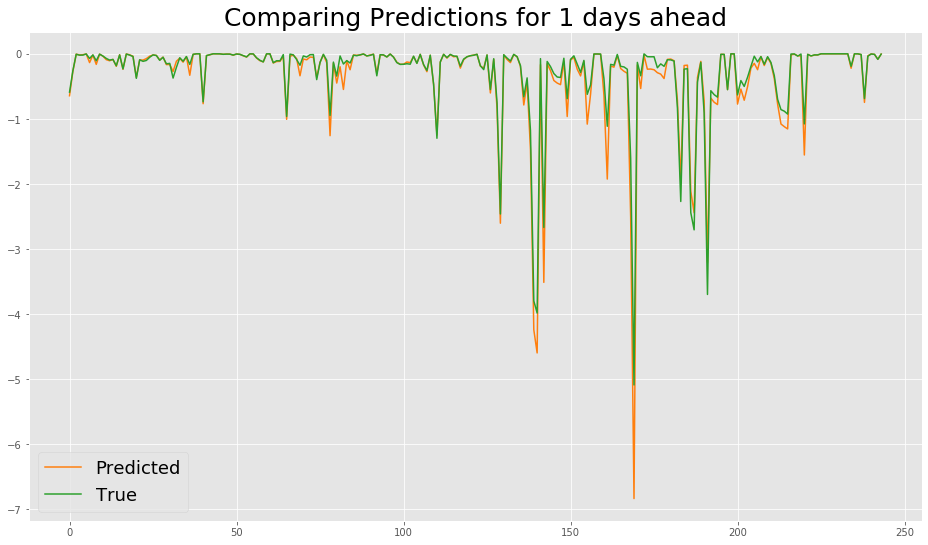

In [321]:
plt.plot(yhat.flatten(), color='tab:orange', label='Predicted')
plt.plot(y_test[test_day,:], color='tab:green', label='True')
plt.title(f'Comparing Predictions for {days} day ahead', fontsize=25)
plt.legend(fontsize=18)
plt.savefig('comparing_predictions_1.png')

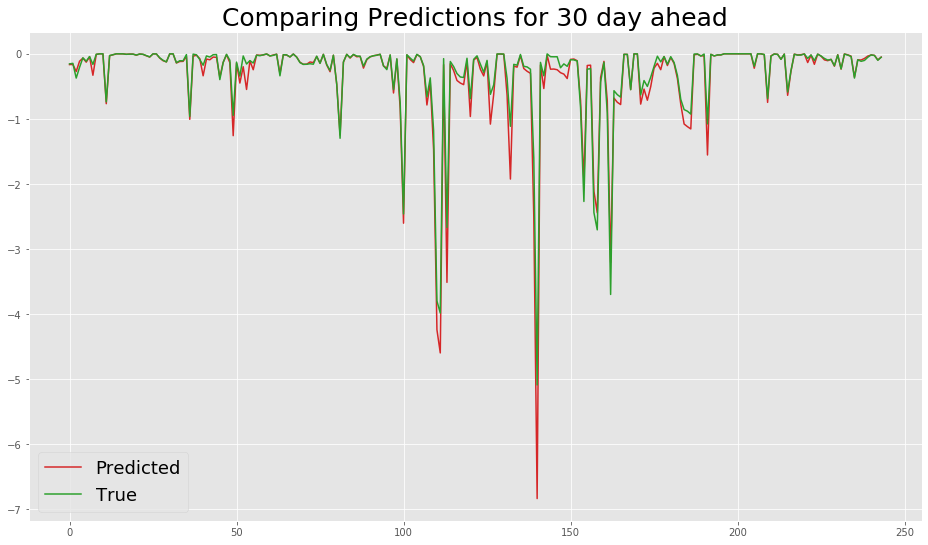

In [329]:
plt.plot(yhat.flatten(), color='tab:red', label='Predicted')
plt.plot(y_test[test_day,:], color='tab:green', label='True')
plt.title(f'Comparing Predictions for {days} days ahead', fontsize=25)
plt.legend(fontsize=18)
plt.savefig('comparing_predictions_2.png')

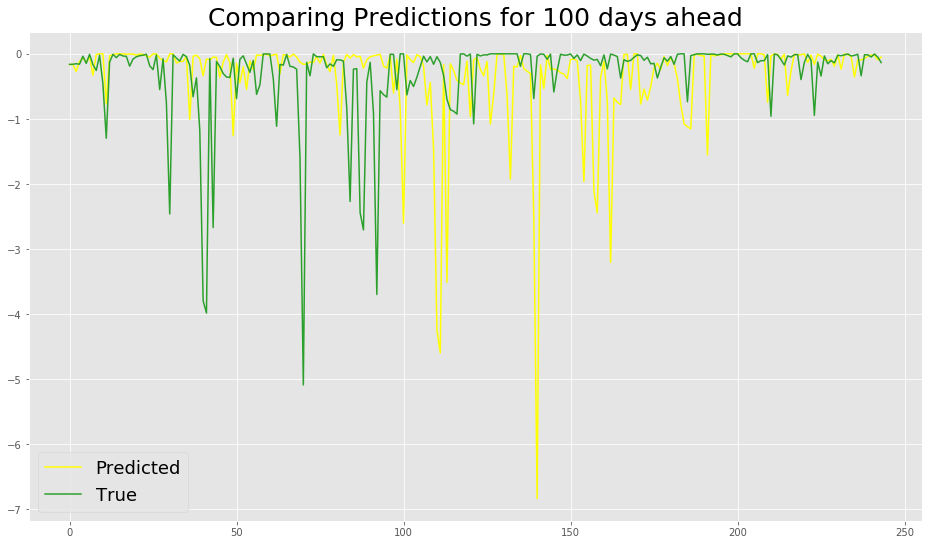

In [336]:
plt.plot(yhat.flatten(), color='yellow', label='Predicted')
plt.plot(y_test[test_day,:], color='tab:green', label='True')
plt.title(f'Comparing Predictions for {days} days ahead', fontsize=25)
plt.legend(fontsize=18)
plt.savefig('comparing_predictions_3.png')